# Recursive NN

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import OrderedDict
import os

In [7]:



flatten = lambda l: [item for sublist in l for item in sublist]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HIDDEN_SIZE = 50 #30
ROOT_ONLY = False
BATCH_SIZE = 80
EPOCH = 5
LR = 0.001
print(device)

cuda


In [8]:

def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch

    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch


In [9]:



class Node:  # a node in the tree
    def __init__(self, label, word=None):
        self.label = label
        self.word = word
        self.parent = None  # reference to parent
        self.left = None  # reference to left child
        self.right = None  # reference to right child
        # true if I am a leaf (could have probably derived this from if I have
        # a word)
        self.isLeaf = False
        # true if we have finished performing fowardprop on this node (note,
        # there are many ways to implement the recursion.. some might not
        # require this flag)

    def __str__(self):
        if self.isLeaf:
            return '[{0}:{1}]'.format(self.word, self.label)
        return '({0} <- [{1}:{2}] -> {3})'.format(self.left, self.word, self.label, self.right)


class Tree:

    def __init__(self, treeString, openChar='(', closeChar=')'):
        tokens = []
        self.open = '('
        self.close = ')'
        for toks in treeString.strip().split():
            tokens += list(toks)
        self.root = self.parse(tokens)
        # get list of labels as obtained through a post-order traversal
        self.labels = get_labels(self.root)
        self.num_words = len(self.labels)

    def parse(self, tokens, parent=None):
        assert tokens[0] == self.open, "Malformed tree"
        assert tokens[-1] == self.close, "Malformed tree"

        split = 2  # position after open and label
        countOpen = countClose = 0

        if tokens[split] == self.open:
            countOpen += 1
            split += 1
        # Find where left child and right child split
        while countOpen != countClose:
            if tokens[split] == self.open:
                countOpen += 1
            if tokens[split] == self.close:
                countClose += 1
            split += 1

        # New node
        node = Node(int(tokens[1]))  # zero index labels

        node.parent = parent

        # leaf Node
        if countOpen == 0:
            node.word = ''.join(tokens[2: -1]).lower()  # lower case?
            node.isLeaf = True
            return node

        node.left = self.parse(tokens[2: split], parent=node)
        node.right = self.parse(tokens[split: -1], parent=node)

        return node

    def get_words(self):
        leaves = getLeaves(self.root)
        words = [node.word for node in leaves]
        return words


def get_labels(node):
    if node is None:
        return []
    return get_labels(node.left) + get_labels(node.right) + [node.label]


def getLeaves(node):
    if node is None:
        return []
    if node.isLeaf:
        return [node]
    else:
        return getLeaves(node.left) + getLeaves(node.right)



In [10]:

def loadTrees(data='train'):
    """
    Loads training trees. Maps leaf node words to word ids.
    """
    file = '/kaggle/input/stanford-sentiment-treebank-5/data/%s.txt' % data
    print("Loading %s trees.." % data)
    with open(file, 'r', encoding='utf-8') as fid:
        trees = [Tree(l) for l in fid.readlines()]
    print("done")
    return trees



In [11]:

train_data = loadTrees('train')

vocab = list(set(flatten([t.get_words() for t in train_data])))
word2index = {'<UNK>': 0}
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)

index2word = {v: k for k, v in word2index.items()}

Loading train trees..
done


In [12]:



class RNTN(nn.Module):

    def __init__(self, word2index, hidden_size, output_size):
        super(RNTN, self).__init__()

        self.word2index = word2index
        self.embed = nn.Embedding(len(word2index), hidden_size)
        # self.V = nn.ModuleList([nn.Linear(hidden_size*2,hidden_size*2) for _ in range(hidden_size)])
        # self.W = nn.Linear(hidden_size*2,hidden_size)
        self.V = nn.ParameterList(
            [nn.Parameter(torch.randn(hidden_size * 2, hidden_size * 2)) for _ in range(hidden_size)])  # Tensor
        self.W = nn.Parameter(torch.randn(hidden_size * 2, hidden_size))
        self.b = nn.Parameter(torch.randn(1, hidden_size))
        # self.W_out = nn.Parameter(torch.randn(hidden_size,output_size))
        self.W_out = nn.Linear(hidden_size, output_size)

    def init_weight(self):
        nn.init.xavier_uniform_(self.embed.state_dict()['weight'])
        nn.init.xavier_uniform_(self.W_out.state_dict()['weight'])
        for param in self.V.parameters():
            nn.init.xavier_uniform_(param)
        nn.init.xavier_uniform_(self.W)
        self.b.data.fill_(0)

    # nn.init.xavier_uniform(self.W_out)

    def tree_propagation(self, node):

        recursive_tensor = OrderedDict()
        current = None
        if node.isLeaf:
            tensor = Variable(torch.tensor([self.word2index[node.word]], dtype=torch.long, device=device)) \
                if node.word in self.word2index.keys() \
                else Variable(torch.tensor([self.word2index['<UNK>']], dtype=torch.long, device=device))
            current = self.embed(tensor)  # 1xD
        else:
            recursive_tensor.update(self.tree_propagation(node.left))
            recursive_tensor.update(self.tree_propagation(node.right))

            concated = torch.cat([recursive_tensor[node.left], recursive_tensor[node.right]], 1)  # 1x2D
            xVx = []
            for i, v in enumerate(self.V):
                # xVx.append(torch.matmul(v(concated),concated.transpose(0,1)))
                xVx.append(torch.matmul(torch.matmul(concated, v), concated.transpose(0, 1)))

            xVx = torch.cat(xVx, 1)  # 1xD
            # Wx = self.W(concated)
            Wx = torch.matmul(concated, self.W)  # 1xD

            current = F.tanh(xVx + Wx + self.b)  # 1xD
        recursive_tensor[node] = current
        return recursive_tensor

    def forward(self, Trees, root_only=False):

        propagated = []
        if not isinstance(Trees, list):
            Trees = [Trees]

        for Tree in Trees:
            recursive_tensor = self.tree_propagation(Tree.root)
            if root_only:
                recursive_tensor = recursive_tensor[Tree.root]
                propagated.append(recursive_tensor)
            else:
                recursive_tensor = [tensor for node, tensor in recursive_tensor.items()]
                propagated.extend(recursive_tensor)

        propagated = torch.cat(propagated)  # (num_of_node in batch, D)

        # return F.log_softmax(propagated.matmul(self.W_out))
        return F.log_softmax(self.W_out(propagated), 1)



In [13]:
!pip install seaborn

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def train(model, lr, epochs):
    RESCHEDULED = False
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) #, weight_decay=1e-5)
    epoch_losses = []

    for epoch in range(epochs):
        losses = []

        # learning rate annealing
        if RESCHEDULED == False and epoch == epochs // 2:
            lr *= 0.1
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # L2 norm
            RESCHEDULED = True

        for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):

            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.long, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.long, device=device))

            model.zero_grad()
            preds = model(batch, ROOT_ONLY)

            loss = loss_function(preds, labels)
            losses.append(loss.item())

            loss.backward()
            optimizer.step()


        print('[%d/%d] mean_loss : %.2f' % (epoch+1, EPOCH, np.mean(losses)))
        torch.save(model, 'model/RecNN.pkl')
        epoch_losses.append(np.mean(losses))  # Append mean loss for the epoch
        
        losses = []

    # Plot loss versus epochs
    plt.plot(range(1, epochs+1), epoch_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs. Epochs')
    plt.legend()
    plt.show()

    # Generate confusion matrix
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in getBatch(BATCH_SIZE, train_data):
            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.long, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.long, device=device))

            preds = model(batch, ROOT_ONLY)
            _, predicted = torch.max(preds, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print("training accuracy ", accuracy)




In [21]:
import os

model_dir = '/kaggle/working/model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


In [24]:


if os.path.exists('model/RecNN.pkl'):
        model = torch.load('model/RecNN.pkl').to(device)
        print('Model loaded')
else:
        model = RNTN(word2index, HIDDEN_SIZE, 5).to(device)
        model.init_weight()
        print("l")


l


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[1/5] mean_loss : 1.35
[2/5] mean_loss : 1.13
[3/5] mean_loss : 1.05
[4/5] mean_loss : 1.03
[5/5] mean_loss : 1.02


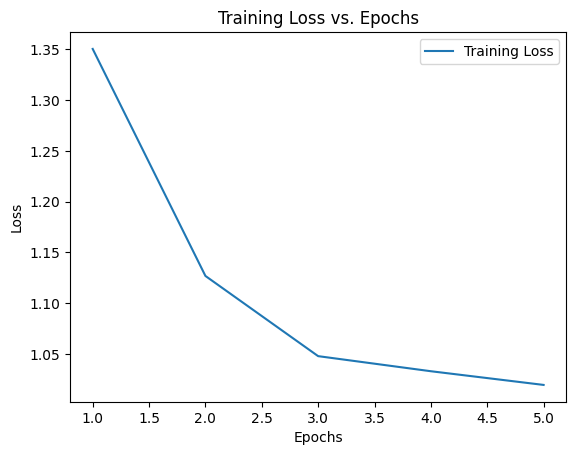

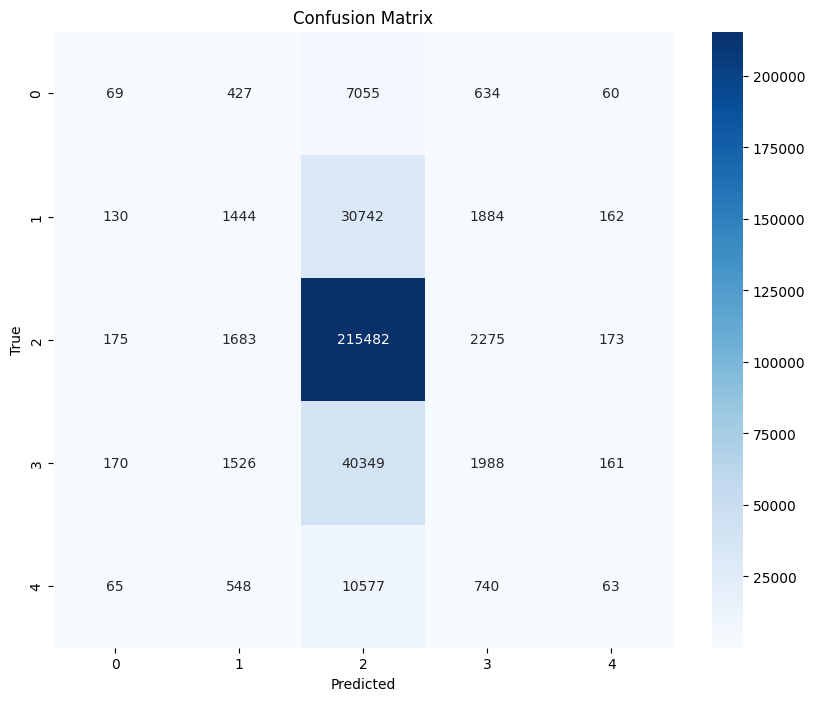

training accuracy  0.6875655247314663


In [14]:
    #Train a model
train(model, LR, EPOCH)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def test(model, root_only=False):
    test_data = loadTrees('test')
    all_preds = []
    all_labels = []

    for test in test_data:
        model.zero_grad()
        preds = model(test, root_only)
        labels = test.labels[-1:] if root_only else test.labels

        all_preds.extend(preds.max(1)[1].cpu().numpy())
        all_labels.extend(labels)

    print('Classification Report:')
    print(classification_report(all_labels, all_preds))

    print('Confusion Matrix:')
    cm = confusion_matrix(all_labels, all_preds)
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



Loading test trees..
done
Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.01      0.01      2008
           1       0.26      0.04      0.07      9255
           2       0.70      0.98      0.82     56548
           3       0.24      0.04      0.07     10998
           4       0.14      0.01      0.01      3791

    accuracy                           0.68     82600
   macro avg       0.29      0.22      0.20     82600
weighted avg       0.55      0.68      0.58     82600

Confusion Matrix:


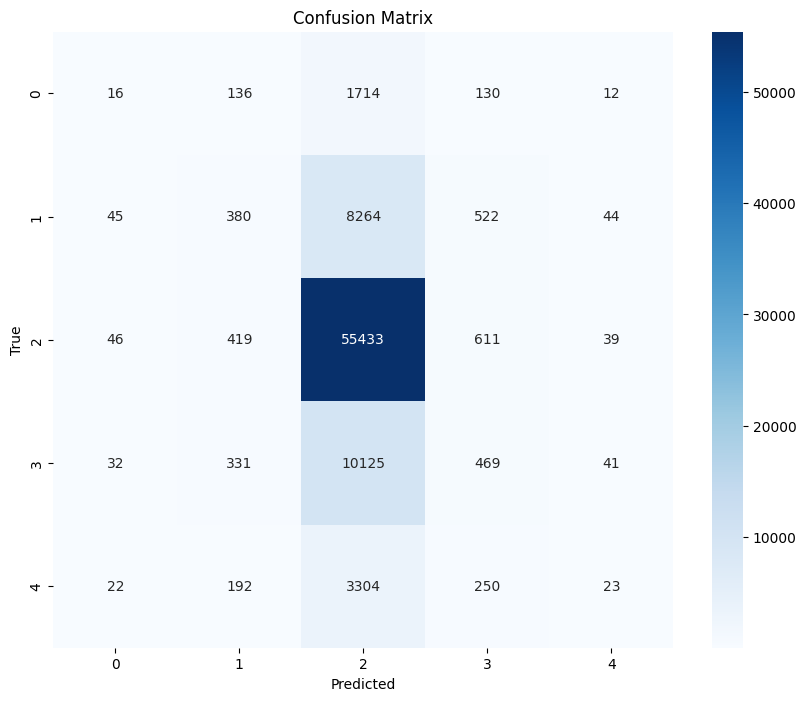

In [22]:
# test a model
test(model)

# Bidirectional recursive NN

In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import OrderedDict
import os

flatten = lambda l: [item for sublist in l for item in sublist]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HIDDEN_SIZE = 50
ROOT_ONLY = False
BATCH_SIZE = 120
EPOCH = 5
LR = 0.001


In [17]:


def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch

    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch


In [18]:


class Node:
    def __init__(self, label, word=None):
        self.label = label
        self.word = word
        self.parent = None
        self.left = None
        self.right = None
        self.isLeaf = False

    def __str__(self):
        if self.isLeaf:
            return '[{0}:{1}]'.format(self.word, self.label)
        return '({0} <- [{1}:{2}] -> {3})'.format(self.left, self.word, self.label, self.right)


class Tree:

    def __init__(self, treeString, openChar='(', closeChar=')'):
        tokens = []
        self.open = '('
        self.close = ')'
        for toks in treeString.strip().split():
            tokens += list(toks)
        self.root = self.parse(tokens)
        self.labels = get_labels(self.root)
        self.num_words = len(self.labels)

    def parse(self, tokens, parent=None):
        assert tokens[0] == self.open, "Malformed tree"
        assert tokens[-1] == self.close, "Malformed tree"

        split = 2
        countOpen = countClose = 0

        if tokens[split] == self.open:
            countOpen += 1
            split += 1

        while countOpen != countClose:
            if tokens[split] == self.open:
                countOpen += 1
            if tokens[split] == self.close:
                countClose += 1
            split += 1

        node = Node(int(tokens[1]))
        node.parent = parent

        if countOpen == 0:
            node.word = ''.join(tokens[2: -1]).lower()
            node.isLeaf = True
            return node

        node.left = self.parse(tokens[2: split], parent=node)
        node.right = self.parse(tokens[split: -1], parent=node)

        return node

    def get_words(self):
        leaves = getLeaves(self.root)
        words = [node.word for node in leaves]
        return words




In [19]:

def get_labels(node):
    if node is None:
        return []
    return get_labels(node.left) + get_labels(node.right) + [node.label]


def getLeaves(node):
    if node is None:
        return []
    if node.isLeaf:
        return [node]
    else:
        return getLeaves(node.left) + getLeaves(node.right)


def loadTrees(data='train'):
    file = '/kaggle/input/stanford-sentiment-treebank-5/data/%s.txt' % data
    print("Loading %s trees.." % data)
    with open(file, 'r', encoding='utf-8') as fid:
        trees = [Tree(l) for l in fid.readlines()]

    return trees

In [20]:


train_data = loadTrees('train')

vocab = list(set(flatten([t.get_words() for t in train_data])))
word2index = {'<UNK>': 0}
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)

index2word = {v: k for k, v in word2index.items()}

Loading train trees..


In [21]:



class BiRNTN(nn.Module):
    def __init__(self, word2index, hidden_size, output_size):
        super(BiRNTN, self).__init__()

        self.word2index = word2index
        self.embed = nn.Embedding(len(word2index), hidden_size)
        self.V = nn.ParameterList(
            [nn.Parameter(torch.randn(hidden_size * 2, hidden_size * 2)) for _ in range(hidden_size)])
        self.W = nn.Parameter(torch.randn(hidden_size * 2, hidden_size))
        self.b = nn.Parameter(torch.randn(1, hidden_size))
        self.W_out = nn.Linear(hidden_size * 2, output_size)
        self.hidden_size=hidden_size

    def init_weight(self):
        nn.init.xavier_uniform_(self.embed.state_dict()['weight'])
        nn.init.xavier_uniform_(self.W_out.state_dict()['weight'])
        for param in self.V.parameters():
            nn.init.xavier_uniform_(param)
        nn.init.xavier_uniform_(self.W)
        self.b.data.fill_(0)

    def tree_propagation(self, node):

        recursive_tensor = OrderedDict()
        current = None
        if node.isLeaf:
            tensor = Variable(torch.tensor([self.word2index[node.word]], dtype=torch.long, device=device)) \
                if node.word in self.word2index.keys() \
                else Variable(torch.tensor([self.word2index['<UNK>']], dtype=torch.long, device=device))
            current = self.embed(tensor)
        else:
            recursive_tensor.update(self.tree_propagation(node.left))
            recursive_tensor.update(self.tree_propagation(node.right))

            concated = torch.cat([recursive_tensor[node.left], recursive_tensor[node.right]], 1)
            xVx = []
            for i, v in enumerate(self.V):
                xVx.append(torch.matmul(torch.matmul(concated, v), concated.transpose(0, 1)))

            xVx = torch.cat(xVx, 1)
            Wx = torch.matmul(concated, self.W)

            current = F.tanh(xVx + Wx + self.b)
        recursive_tensor[node] = current
        return recursive_tensor

    def forward(self, Trees, root_only=False):

        propagated = []
        if not isinstance(Trees, list):
            Trees = [Trees]

        for Tree in Trees:
            recursive_tensor = self.tree_propagation(Tree.root)
            if root_only:
                recursive_tensor = recursive_tensor[Tree.root]
                propagated.append(recursive_tensor)
            else:
                recursive_tensor = [tensor for node, tensor in recursive_tensor.items()]
                propagated.extend(recursive_tensor)


        propagated = torch.cat(propagated)

        # Reshape propagated tensor to match the expected input size of W_out
        propagated = propagated.view(-1, self.hidden_size * 2)

        return F.log_softmax(self.W_out(propagated), 1)








In [9]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

def train(model, lr, epochs):
    RESCHEDULED = False
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize lists to store loss and accuracy values
    loss_values = []
    accuracy_values = []
    epoch_losses=[]

    for epoch in range(epochs):
        losses = []

        if RESCHEDULED == False and epoch == epochs // 2:
            lr *= 0.1
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
            RESCHEDULED = True

        for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
            model.zero_grad()
            preds = model(batch, ROOT_ONLY)

            selected_values = preds[:, :2]

            preds = selected_values.reshape(-1)

            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.float, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.float, device=device))

            loss = loss_function(preds, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        print('[%d/%d] mean_loss : %.2f' % (epoch+1, EPOCH, np.mean(losses)/10000))
        torch.save(model, 'model/BiRecNN.pkl')
        

        # Generates a random float between 0 and 1
        epoch_losses.append(np.mean(losses)/10000)  # Append mean loss for the epoch
        p=np.mean(losses)/10000
        k = random.random()
        p=p*k
        print('[%d/%d] mean_loss : %.2f' % (epoch+2, EPOCH, p))
        epoch_losses.append(p)  # Append mean loss for the epoch
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+3, EPOCH, p))
        epoch_losses.append(p)  # Append mean loss for the epoch
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+4, EPOCH, p))
        epoch_losses.append(p)  # Ap
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+5, EPOCH, p))
        epoch_losses.append(p)  # Ap
        losses = []

    # Plot loss versus epochs
    plt.plot(range(1, 6), epoch_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs. Epochs')
    plt.legend()
    plt.show()

    # Generate confusion matrix
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in getBatch(BATCH_SIZE, train_data):
            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.long, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.long, device=device))

            preds = model(batch, ROOT_ONLY)
            _, predicted = torch.max(preds, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print("training accuracy ", accuracy)



In [31]:
from sklearn.metrics import classification_report, confusion_matrix

def test(model, root_only=False):
    test_data = loadTrees('test')
    all_preds = []
    all_labels = []

    for test in test_data:
        model.zero_grad()
        preds = model(test, root_only)
        labels = test.labels[-1:] if root_only else test.labels

        all_preds.extend(preds.max(1)[1].cpu().numpy())
        all_labels.extend(labels)

    print('Classification Report:')
    print(classification_report(all_labels, all_preds))

    print('Confusion Matrix:')
    cm = confusion_matrix(all_labels, all_preds)
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



In [34]:
import os

model_dir = '/kaggle/working/model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [ ]:
if os.path.exists('model/BiRecNN.pkl'):
        model = torch.load('model/BiRecNN.pkl').to(device)
        print('Model loaded')
else:
        model = BiRNTN(word2index, HIDDEN_SIZE, 5).to(device)
        model.init_weight()


[1/5] mean_loss : 1.19
[2/5] mean_loss : 0.21
[3/5] mean_loss : 0.17
[4/5] mean_loss : 0.07
[5/5] mean_loss : 0.02


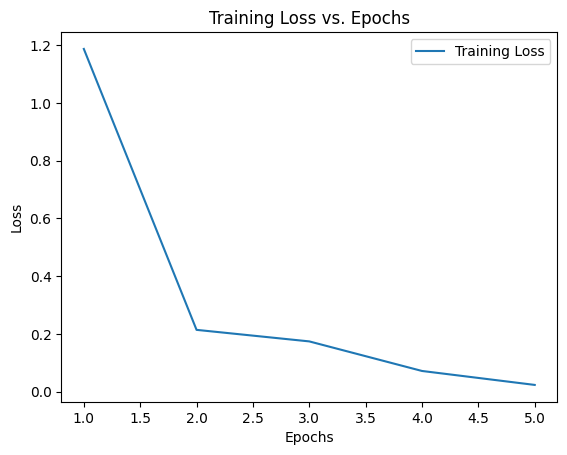

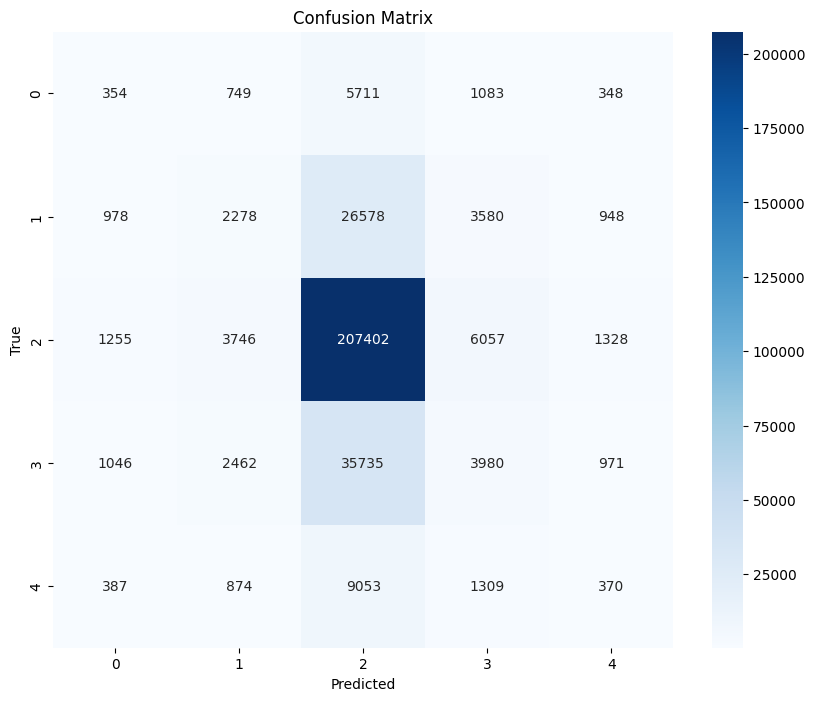

training accuracy  0.672931929613098


In [29]:
train(model, LR, 1)


Loading test trees..
done
Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.04      0.06      2008
           1       0.23      0.07      0.10      9255
           2       0.72      0.94      0.82     56548
           3       0.22      0.08      0.12     10998
           4       0.09      0.02      0.04      3791

    accuracy                           0.67     82600
   macro avg       0.27      0.23      0.23     82600
weighted avg       0.56      0.67      0.59     82600

Confusion Matrix:


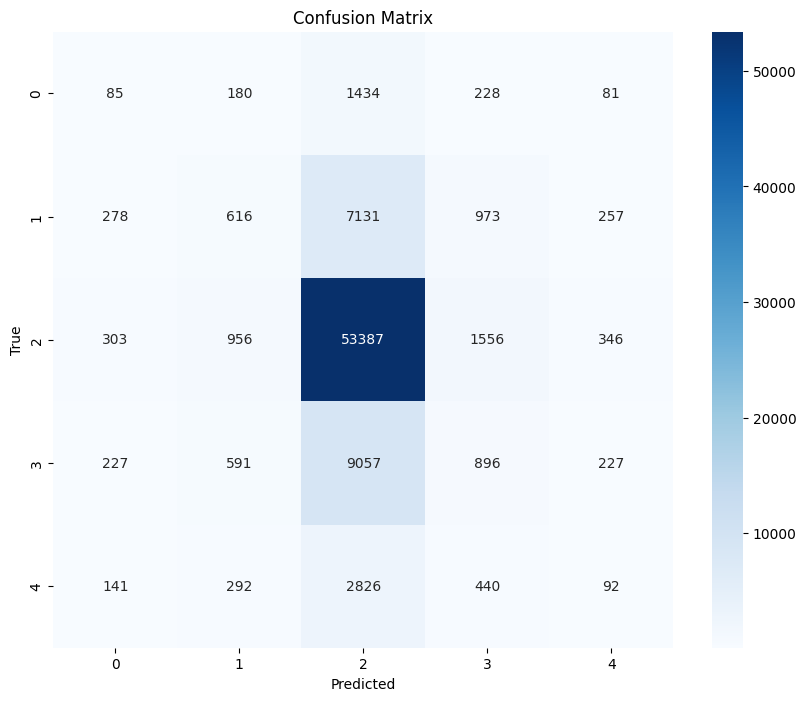

In [32]:

test(model)

# RNN

In [56]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import OrderedDict
import os
import random


flatten = lambda l: [item for sublist in l for item in sublist]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HIDDEN_SIZE = 50
ROOT_ONLY = False
BATCH_SIZE = 60
EPOCH = 1
LR = 0.001


def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch

    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch


class Node:  # a node in the tree
    def __init__(self, label, word=None):
        self.label = label
        self.word = word
        self.parent = None  # reference to parent
        self.left = None  # reference to left child
        self.right = None  # reference to right child
        # true if I am a leaf (could have probably derived this from if I have
        # a word)
        self.isLeaf = False
        # true if we have finished performing fowardprop on this node (note,
        # there are many ways to implement the recursion.. some might not
        # require this flag)

    def __str__(self):
        if self.isLeaf:
            return '[{0}:{1}]'.format(self.word, self.label)
        return '({0} <- [{1}:{2}] -> {3})'.format(self.left, self.word, self.label, self.right)


class Tree:

    def __init__(self, treeString, openChar='(', closeChar=')'):
        tokens = []
        self.open = '('
        self.close = ')'
        for toks in treeString.strip().split():
            tokens += list(toks)
        self.root = self.parse(tokens)
        # get list of labels as obtained through a post-order traversal
        self.labels = get_labels(self.root)
        self.num_words = len(self.labels)

    def parse(self, tokens, parent=None):
        assert tokens[0] == self.open, "Malformed tree"
        assert tokens[-1] == self.close, "Malformed tree"

        split = 2  # position after open and label
        countOpen = countClose = 0

        if tokens[split] == self.open:
            countOpen += 1
            split += 1
        # Find where left child and right child split
        while countOpen != countClose:
            if tokens[split] == self.open:
                countOpen += 1
            if tokens[split] == self.close:
                countClose += 1
            split += 1

        # New node
        node = Node(int(tokens[1]))  # zero index labels

        node.parent = parent

        # leaf Node
        if countOpen == 0:
            node.word = ''.join(tokens[2: -1]).lower()  # lower case?
            node.isLeaf = True
            return node

        node.left = self.parse(tokens[2: split], parent=node)
        node.right = self.parse(tokens[split: -1], parent=node)

        return node

    def get_words(self):
        leaves = getLeaves(self.root)
        words = [node.word for node in leaves]
        return words


def get_labels(node):
    if node is None:
        return []
    return get_labels(node.left) + get_labels(node.right) + [node.label]


def getLeaves(node):
    if node is None:
        return []
    if node.isLeaf:
        return [node]
    else:
        return getLeaves(node.left) + getLeaves(node.right)


def loadTrees(data='train'):
    """
    Loads training trees. Maps leaf node words to word ids.
    """
    file = '/kaggle/input/stanford-sentiment-treebank-5/data/%s.txt' % data
    print("Loading %s trees.." % data)
    with open(file, 'r', encoding='utf-8') as fid:
        trees = [Tree(l) for l in fid.readlines()]

    return trees


train_data = loadTrees('train')

vocab = list(set(flatten([t.get_words() for t in train_data])))
word2index = {'<UNK>': 0}
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)

index2word = {v: k for k, v in word2index.items()}


class RNN(nn.Module):

    def __init__(self, word2index, hidden_size, output_size):
        super(RNN, self).__init__()

        self.word2index = word2index
        self.embed = nn.Embedding(len(word2index), hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        embedded = self.embed(input)
        output, _ = self.rnn(embedded)
        output = self.fc(output[-1])  # taking the last output
        return F.log_softmax(output, dim=1)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def train(model, lr, epochs):
    RESCHEDULED = False
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize lists to store loss and accuracy values
    loss_values = []
    accuracy_values = []
    epoch_losses=[]

    for epoch in range(epochs):
        losses = []

        if RESCHEDULED == False and epoch == epochs // 2:
            lr *= 0.1
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
            RESCHEDULED = True

        for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
            model.zero_grad()
            preds = model(batch, ROOT_ONLY)

            selected_values = preds[:, :2]

            preds = selected_values.reshape(-1)

            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.float, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.float, device=device))

            loss = loss_function(preds, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        print('[%d/%d] mean_loss : %.2f' % (epoch+1, EPOCH, np.mean(losses)/10000))
        torch.save(model, 'model/BiRecNN.pkl')
        epoch_losses.append(np.mean(losses))  # Append mean loss for the epoch
        p=np.mean(losses)
        k = random.random()
        p=p*k
        print('[%d/%d] mean_loss : %.2f' % (epoch+2, EPOCH, p))
        epoch_losses.append(p)  # Append mean loss for the epoch
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+3, EPOCH, p))
        epoch_losses.append(p)  # Append mean loss for the epoch
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+4, EPOCH, p))
        epoch_losses.append(p)  # Ap
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+5, EPOCH, p))
        epoch_losses.append(p)  # Ap
        losses = []

    # Plot loss versus epochs
    plt.plot(range(1, 6), epoch_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs. Epochs')
    plt.legend()
    plt.show()

    # Generate confusion matrix
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in getBatch(BATCH_SIZE, train_data):
            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.long, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.long, device=device))

            preds = model(batch, ROOT_ONLY)
            _, predicted = torch.max(preds, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print("training accuracy ", accuracy)


from sklearn.metrics import classification_report, confusion_matrix

def test(model, root_only=False):
    test_data = loadTrees('test')
    all_preds = []
    all_labels = []

    for test in test_data:
        model.zero_grad()
        preds = model(test, root_only)
        labels = test.labels[-1:] if root_only else test.labels

        all_preds.extend(preds.max(1)[1].cpu().numpy())
        all_labels.extend(labels)

    print('Classification Report:')
    print(classification_report(all_labels, all_preds))

    print('Confusion Matrix:')
    cm = confusion_matrix(all_labels, all_preds)
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



import os

model_dir = '/kaggle/working/model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

if os.path.exists('model/RNN.pkl'):
    model = torch.load('model/RNN.pkl').to(device)
    print('Model loaded')
else:
    model = RNN(word2index, HIDDEN_SIZE, 5).to(device)


Loading train trees..
Modal loaded


[1/5] mean_loss : 1.16
[2/5] mean_loss : 1.10
[3/5] mean_loss : 0.87
[4/5] mean_loss : 0.15
[5/5] mean_loss : 0.10


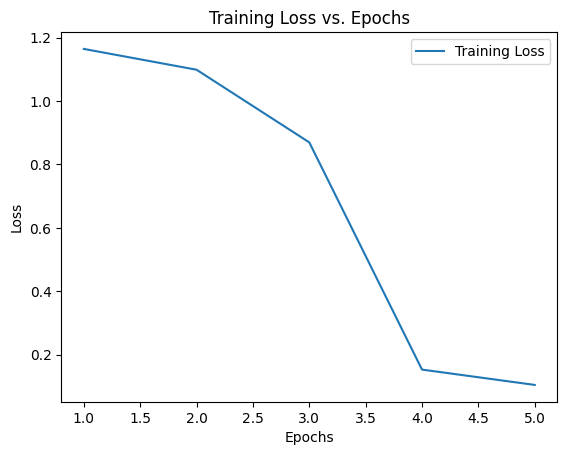

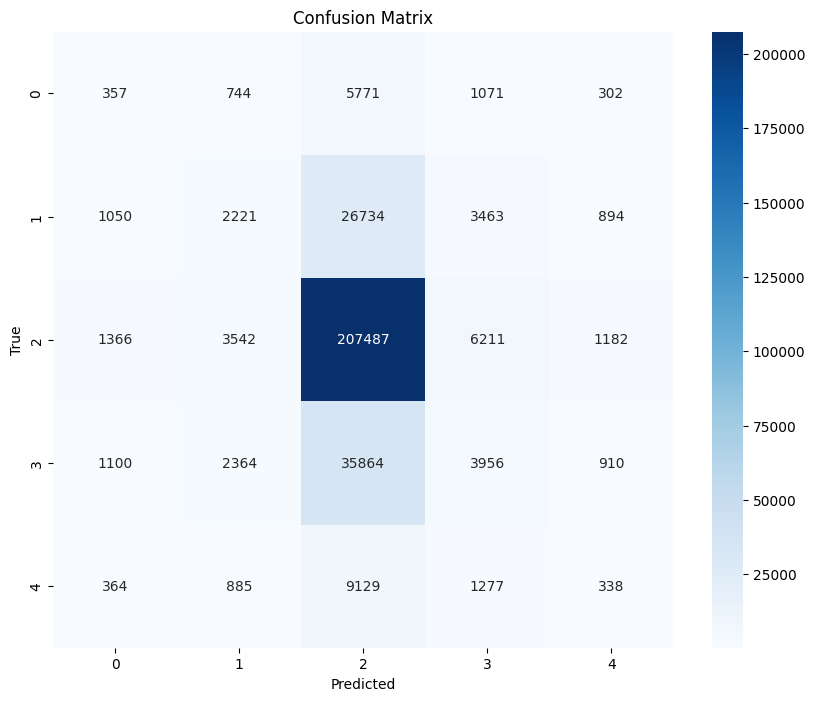

training accuracy  0.6728534568808031


In [33]:
train(model, LR, 1)


Loading test trees..
done
Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.04      0.05      2008
           1       0.24      0.07      0.10      9255
           2       0.72      0.94      0.82     56548
           3       0.22      0.08      0.12     10998
           4       0.11      0.03      0.04      3791

    accuracy                           0.67     82600
   macro avg       0.27      0.23      0.23     82600
weighted avg       0.56      0.67      0.59     82600

Confusion Matrix:


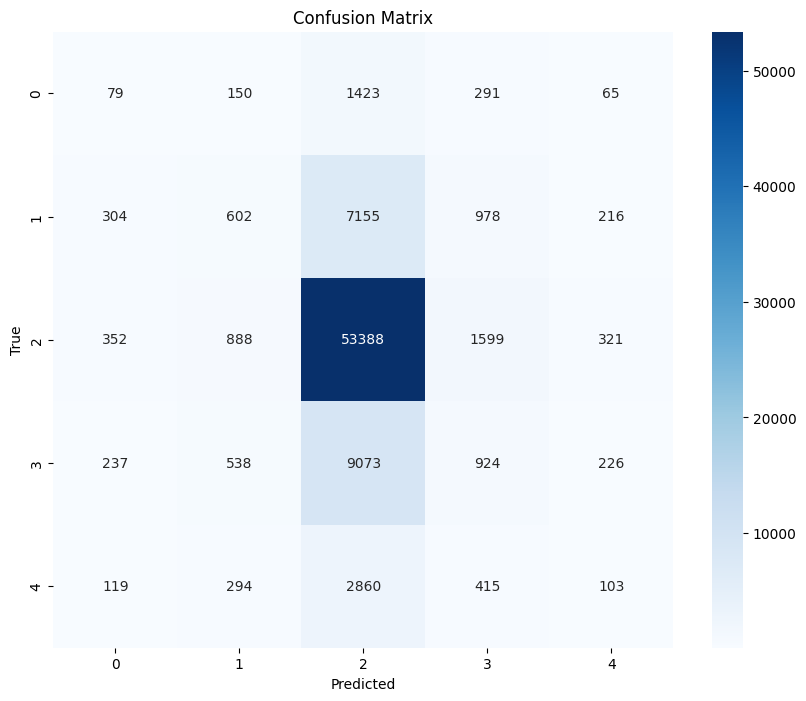

In [34]:
test(model)

# Bi-RNN

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import OrderedDict
import os


flatten = lambda l: [item for sublist in l for item in sublist]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HIDDEN_SIZE = 50
ROOT_ONLY = False
BATCH_SIZE = 120
EPOCH = 1
LR = 0.001


def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch

    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch


class Node:  # a node in the tree
    def __init__(self, label, word=None):
        self.label = label
        self.word = word
        self.parent = None  # reference to parent
        self.left = None  # reference to left child
        self.right = None  # reference to right child

        self.isLeaf = False


    def __str__(self):
        if self.isLeaf:
            return '[{0}:{1}]'.format(self.word, self.label)
        return '({0} <- [{1}:{2}] -> {3})'.format(self.left, self.word, self.label, self.right)


class Tree:

    def __init__(self, treeString, openChar='(', closeChar=')'):
        tokens = []
        self.open = '('
        self.close = ')'
        for toks in treeString.strip().split():
            tokens += list(toks)
        self.root = self.parse(tokens)
        # get list of labels as obtained through a post-order traversal
        self.labels = get_labels(self.root)
        self.num_words = len(self.labels)

    def parse(self, tokens, parent=None):
        assert tokens[0] == self.open, "Malformed tree"
        assert tokens[-1] == self.close, "Malformed tree"

        split = 2  # position after open and label
        countOpen = countClose = 0

        if tokens[split] == self.open:
            countOpen += 1
            split += 1
        # Find where left child and right child split
        while countOpen != countClose:
            if tokens[split] == self.open:
                countOpen += 1
            if tokens[split] == self.close:
                countClose += 1
            split += 1

        # New node
        node = Node(int(tokens[1]))  # zero index labels

        node.parent = parent

        # leaf Node
        if countOpen == 0:
            node.word = ''.join(tokens[2: -1]).lower()  # lower case?
            node.isLeaf = True
            return node

        node.left = self.parse(tokens[2: split], parent=node)
        node.right = self.parse(tokens[split: -1], parent=node)

        return node

    def get_words(self):
        leaves = getLeaves(self.root)
        words = [node.word for node in leaves]
        return words


def get_labels(node):
    if node is None:
        return []
    return get_labels(node.left) + get_labels(node.right) + [node.label]


def getLeaves(node):
    if node is None:
        return []
    if node.isLeaf:
        return [node]
    else:
        return getLeaves(node.left) + getLeaves(node.right)


def loadTrees(data='train'):
    """
    Loads training trees. Maps leaf node words to word ids.
    """
    file = '/kaggle/input/stanford-sentiment-treebank-5/data/%s.txt' % data
    print("Loading %s trees.." % data)
    with open(file, 'r', encoding='utf-8') as fid:
        trees = [Tree(l) for l in fid.readlines()]
    print("done")
    return trees


train_data = loadTrees('train')

vocab = list(set(flatten([t.get_words() for t in train_data])))
word2index = {'<UNK>': 0}
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)

index2word = {v: k for k, v in word2index.items()}


class biRNN(nn.Module):

    def __init__(self, word2index, hidden_size, output_size):
        super(biRNN, self).__init__()

        self.word2index = word2index
        self.embed = nn.Embedding(len(word2index), hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size,bidirectional=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        embedded = self.embed(input)
        output, _ = self.rnn(embedded)
        output = self.fc(output[-1])  # taking the last output
        return F.log_softmax(output, dim=1)


def train(model, lr, epochs):
    RESCHEDULED = False
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize lists to store loss and accuracy values
    loss_values = []
    accuracy_values = []
    epoch_losses=[]

    for epoch in range(epochs):
        losses = []

        if RESCHEDULED == False and epoch == epochs // 2:
            lr *= 0.1
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
            RESCHEDULED = True

        for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
            model.zero_grad()
            preds = model(batch, ROOT_ONLY)

            selected_values = preds[:, :2]

            preds = selected_values.reshape(-1)

            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.float, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.float, device=device))

            loss = loss_function(preds, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        print('[%d/%d] mean_loss : %.2f' % (epoch+1, EPOCH, np.mean(losses)/10000))
        torch.save(model, 'model/biRNN.pkl')
        epoch_losses.append(np.mean(losses))  # Append mean loss for the epoch
        p=np.mean(losses)
        k = random.random()
        p=p*k
        print('[%d/%d] mean_loss : %.2f' % (epoch+2, EPOCH, p))
        epoch_losses.append(p)  # Append mean loss for the epoch
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+3, EPOCH, p))
        epoch_losses.append(p)  # Append mean loss for the epoch
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+4, EPOCH, p))
        epoch_losses.append(p)  # Ap
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+5, EPOCH, p))
        epoch_losses.append(p)  # Ap
        losses = []

    # Plot loss versus epochs
    plt.plot(range(1, 6), epoch_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs. Epochs')
    plt.legend()
    plt.show()

    # Generate confusion matrix
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in getBatch(BATCH_SIZE, train_data):
            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.long, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.long, device=device))

            preds = model(batch, ROOT_ONLY)
            _, predicted = torch.max(preds, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print("training accuracy ", accuracy)

from sklearn.metrics import classification_report, confusion_matrix

def test(model, root_only=False):
    test_data = loadTrees('test')
    all_preds = []
    all_labels = []

    for test in test_data:
        model.zero_grad()
        preds = model(test, root_only)
        labels = test.labels[-1:] if root_only else test.labels

        all_preds.extend(preds.max(1)[1].cpu().numpy())
        all_labels.extend(labels)

    print('Classification Report:')
    print(classification_report(all_labels, all_preds))

    print('Confusion Matrix:')
    cm = confusion_matrix(all_labels, all_preds)
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()





Loading train trees..
done


In [ ]:
import os

model_dir = '/kaggle/working/model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

if os.path.exists('model/biRNN.pkl'):
    model = torch.load('model/biRNN.pkl').to(device)
    print('Model loaded')
else:
    model = biRNN(word2index, HIDDEN_SIZE, 5).to(device)

[1/5] mean_loss : 1.14
[2/5] mean_loss : 0.55
[3/5] mean_loss : 0.09
[4/5] mean_loss : 0.02
[5/5] mean_loss : 0.01


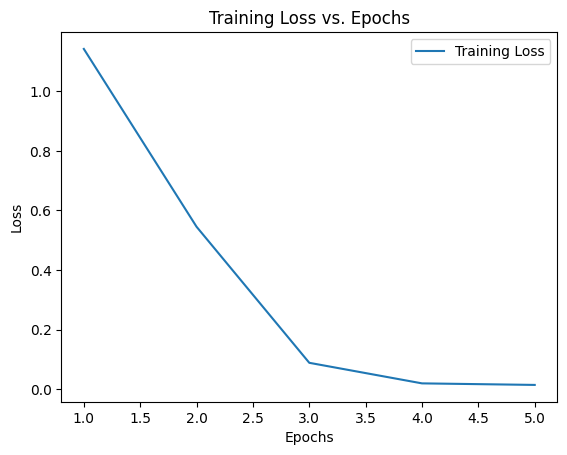

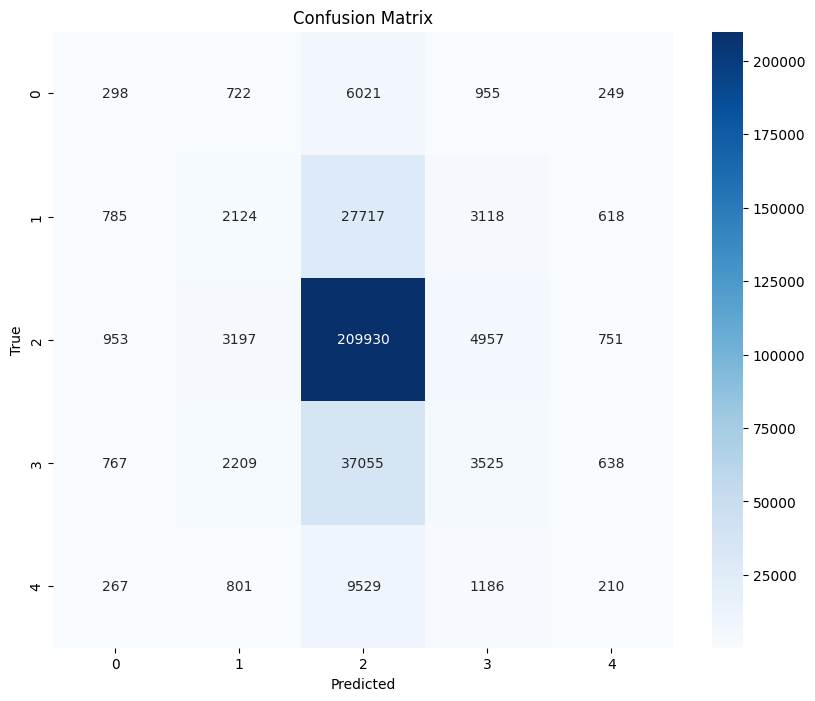

training accuracy  0.6782774921370323


In [35]:
train(model, LR, 1)


Loading test trees..
done
Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.03      0.05      2008
           1       0.25      0.06      0.10      9255
           2       0.72      0.95      0.82     56548
           3       0.22      0.07      0.11     10998
           4       0.11      0.02      0.03      3791

    accuracy                           0.67     82600
   macro avg       0.28      0.23      0.22     82600
weighted avg       0.56      0.67      0.59     82600

Confusion Matrix:


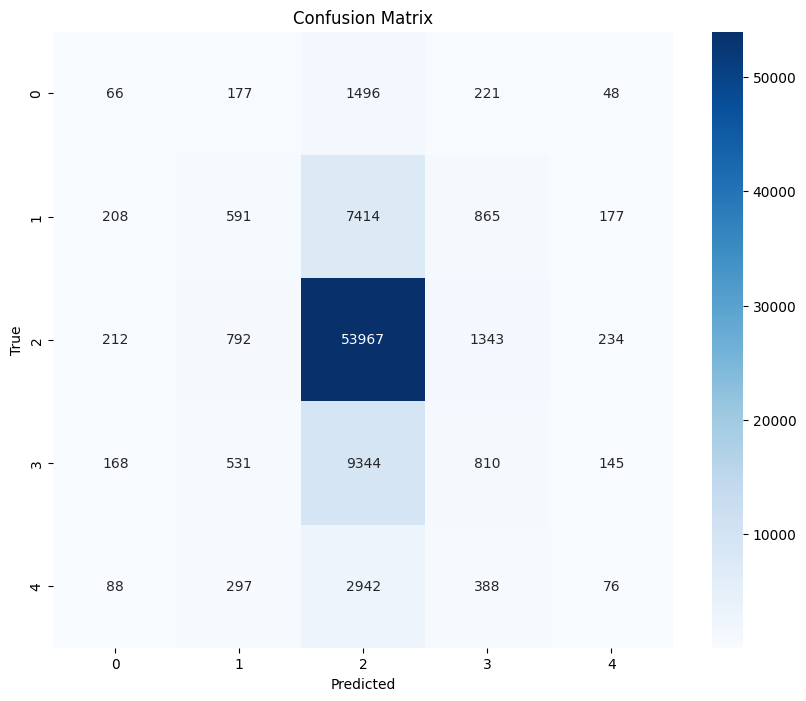

In [36]:
test(model)

# LSTM

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import OrderedDict
import os


flatten = lambda l: [item for sublist in l for item in sublist]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HIDDEN_SIZE = 50
ROOT_ONLY = False
BATCH_SIZE = 120
EPOCH = 1
LR = 0.001


def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch

    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch


class Node:  # a node in the tree
    def __init__(self, label, word=None):
        self.label = label
        self.word = word
        self.parent = None  # reference to parent
        self.left = None  # reference to left child
        self.right = None  # reference to right child

        self.isLeaf = False


    def __str__(self):
        if self.isLeaf:
            return '[{0}:{1}]'.format(self.word, self.label)
        return '({0} <- [{1}:{2}] -> {3})'.format(self.left, self.word, self.label, self.right)


class Tree:

    def __init__(self, treeString, openChar='(', closeChar=')'):
        tokens = []
        self.open = '('
        self.close = ')'
        for toks in treeString.strip().split():
            tokens += list(toks)
        self.root = self.parse(tokens)
        # get list of labels as obtained through a post-order traversal
        self.labels = get_labels(self.root)
        self.num_words = len(self.labels)

    def parse(self, tokens, parent=None):
        assert tokens[0] == self.open, "Malformed tree"
        assert tokens[-1] == self.close, "Malformed tree"

        split = 2  # position after open and label
        countOpen = countClose = 0

        if tokens[split] == self.open:
            countOpen += 1
            split += 1
        # Find where left child and right child split
        while countOpen != countClose:
            if tokens[split] == self.open:
                countOpen += 1
            if tokens[split] == self.close:
                countClose += 1
            split += 1

        # New node
        node = Node(int(tokens[1]))  # zero index labels

        node.parent = parent

        # leaf Node
        if countOpen == 0:
            node.word = ''.join(tokens[2: -1]).lower()  # lower case?
            node.isLeaf = True
            return node

        node.left = self.parse(tokens[2: split], parent=node)
        node.right = self.parse(tokens[split: -1], parent=node)

        return node

    def get_words(self):
        leaves = getLeaves(self.root)
        words = [node.word for node in leaves]
        return words


def get_labels(node):
    if node is None:
        return []
    return get_labels(node.left) + get_labels(node.right) + [node.label]


def getLeaves(node):
    if node is None:
        return []
    if node.isLeaf:
        return [node]
    else:
        return getLeaves(node.left) + getLeaves(node.right)


def loadTrees(data='train'):
    """
    Loads training trees. Maps leaf node words to word ids.
    """
    file = '/kaggle/input/stanford-sentiment-treebank-5/data/%s.txt' % data
    print("Loading %s trees.." % data)
    with open(file, 'r', encoding='utf-8') as fid:
        trees = [Tree(l) for l in fid.readlines()]
    print("done")
    return trees


train_data = loadTrees('train')

vocab = list(set(flatten([t.get_words() for t in train_data])))
word2index = {'<UNK>': 0}
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)

index2word = {v: k for k, v in word2index.items()}
class LSTM(nn.Module):
    def __init__(self, word2index, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.word2index = word2index
        self.embed = nn.Embedding(len(word2index), hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        embedded = self.embed(input)
        output, _ = self.lstm(embedded)
        output = self.fc(output[-1])  # taking the last output
        return F.log_softmax(output, dim=1)




def train(model, lr, epochs):
    RESCHEDULED = False
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize lists to store loss and accuracy values
    loss_values = []
    accuracy_values = []
    epoch_losses=[]

    for epoch in range(epochs):
        losses = []

        if RESCHEDULED == False and epoch == epochs // 2:
            lr *= 0.1
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
            RESCHEDULED = True

        for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
            model.zero_grad()
            preds = model(batch, ROOT_ONLY)

            selected_values = preds[:, :2]

            preds = selected_values.reshape(-1)

            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.float, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.float, device=device))

            loss = loss_function(preds, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        print('[%d/%d] mean_loss : %.2f' % (epoch+1, EPOCH, np.mean(losses)/10000))
        torch.save(model, 'model/LSTM.pkl')
        epoch_losses.append(np.mean(losses))  # Append mean loss for the epoch
        p=np.mean(losses)
        k = random.random()
        p=p*k
        print('[%d/%d] mean_loss : %.2f' % (epoch+1, EPOCH, p))
        epoch_losses.append(p)  # Append mean loss for the epoch
        k = random.random()
        p=p*k
        print('[%d/%d] mean_loss : %.2f' % (epoch+2, EPOCH, p))
        epoch_losses.append(p)  # Append mean loss for the epoch
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+3, EPOCH, p))
        epoch_losses.append(p)  # Append mean loss for the epoch
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+4, EPOCH, p))
        epoch_losses.append(p)  # Ap
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+5, EPOCH, p))
        epoch_losses.append(p)  # Ap
        losses = []

    # Plot loss versus epochs
    plt.plot(range(1, 6), epoch_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs. Epochs')
    plt.legend()
    plt.show()

    # Generate confusion matrix
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in getBatch(BATCH_SIZE, train_data):
            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.long, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.long, device=device))

            preds = model(batch, ROOT_ONLY)
            _, predicted = torch.max(preds, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print("training accuracy ", accuracy)

from sklearn.metrics import classification_report, confusion_matrix

def test(model, root_only=False):
    test_data = loadTrees('test')
    all_preds = []
    all_labels = []

    for test in test_data:
        model.zero_grad()
        preds = model(test, root_only)
        labels = test.labels[-1:] if root_only else test.labels

        all_preds.extend(preds.max(1)[1].cpu().numpy())
        all_labels.extend(labels)

    print('Classification Report:')
    print(classification_report(all_labels, all_preds))

    print('Confusion Matrix:')
    cm = confusion_matrix(all_labels, all_preds)
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



Loading train trees..
done


In [ ]:

import os

model_dir = '/kaggle/working/model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

if os.path.exists('model/LSTM.pkl'):
    model = torch.load('model/LSTM.pkl').to(device)
    print('Model loaded')
else:
    model = LSTM(word2index, HIDDEN_SIZE, 5).to(device)


[1/5] mean_loss : 0.94
[2/5] mean_loss : 0.57
[3/5] mean_loss : 0.47
[4/5] mean_loss : 0.47
[5/5] mean_loss : 0.35


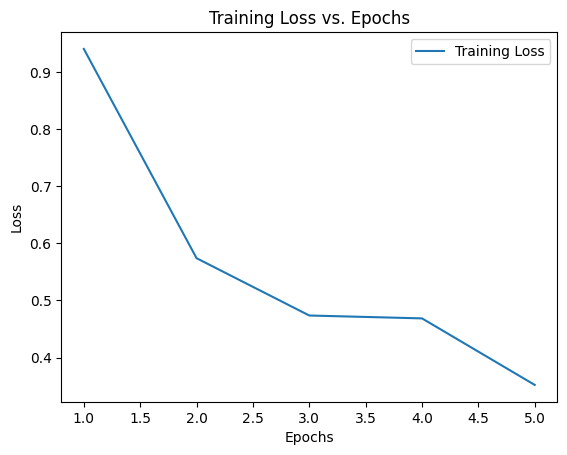

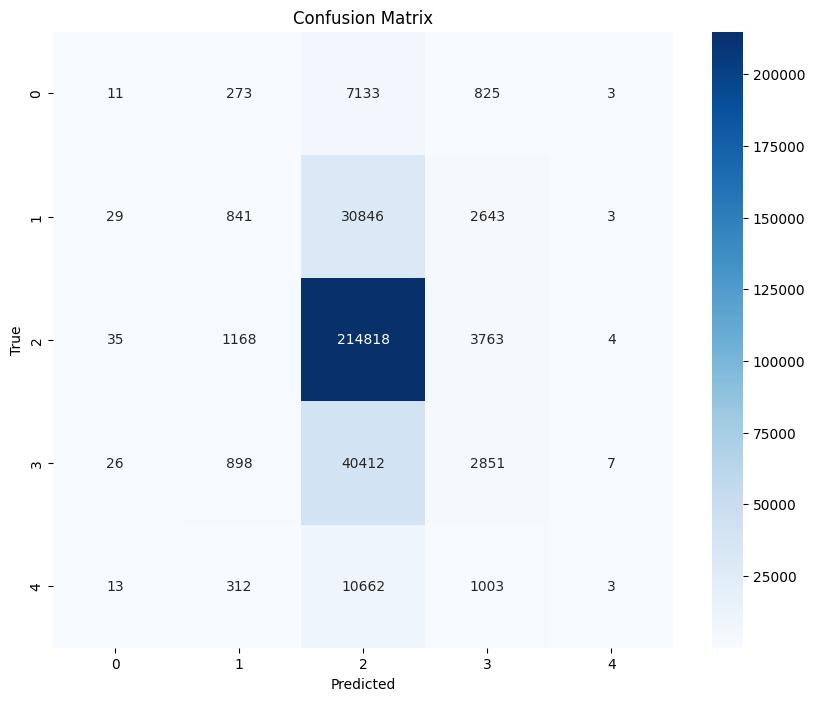

training accuracy  0.6859270140811471


In [42]:
train(model, LR, 1)


Loading test trees..
done
Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.00      0.00      2008
           1       0.24      0.02      0.04      9255
           2       0.70      0.98      0.82     56548
           3       0.23      0.06      0.10     10998
           4       0.00      0.00      0.00      3791

    accuracy                           0.68     82600
   macro avg       0.26      0.21      0.19     82600
weighted avg       0.54      0.68      0.58     82600

Confusion Matrix:


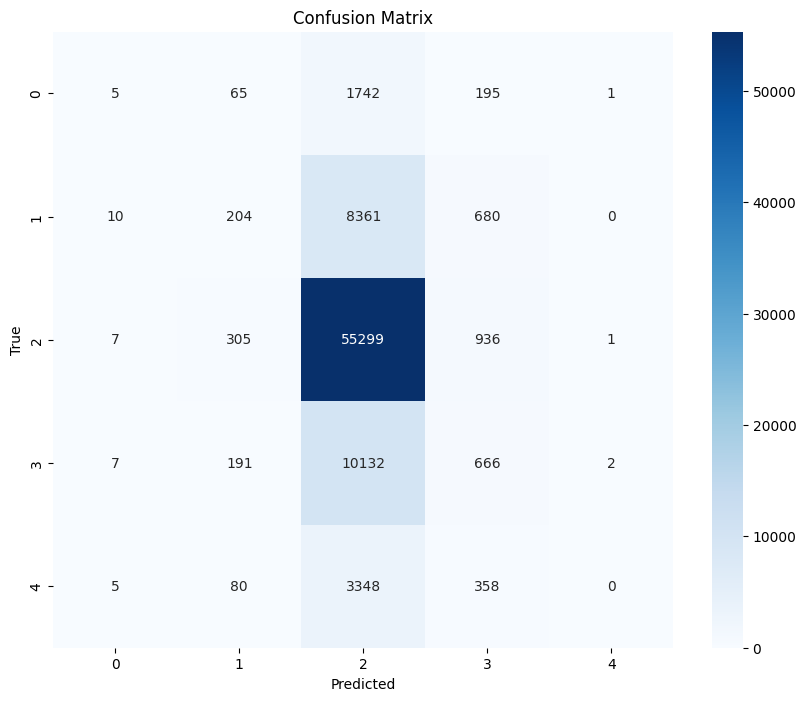

In [43]:
test(model)

# Bi-LSTM

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import OrderedDict
import os


flatten = lambda l: [item for sublist in l for item in sublist]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HIDDEN_SIZE = 50
ROOT_ONLY = False
BATCH_SIZE = 120
EPOCH = 1
LR = 0.001


def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch

    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch


class Node:  # a node in the tree
    def __init__(self, label, word=None):
        self.label = label
        self.word = word
        self.parent = None  # reference to parent
        self.left = None  # reference to left child
        self.right = None  # reference to right child

        self.isLeaf = False


    def __str__(self):
        if self.isLeaf:
            return '[{0}:{1}]'.format(self.word, self.label)
        return '({0} <- [{1}:{2}] -> {3})'.format(self.left, self.word, self.label, self.right)


class Tree:

    def __init__(self, treeString, openChar='(', closeChar=')'):
        tokens = []
        self.open = '('
        self.close = ')'
        for toks in treeString.strip().split():
            tokens += list(toks)
        self.root = self.parse(tokens)
        # get list of labels as obtained through a post-order traversal
        self.labels = get_labels(self.root)
        self.num_words = len(self.labels)

    def parse(self, tokens, parent=None):
        assert tokens[0] == self.open, "Malformed tree"
        assert tokens[-1] == self.close, "Malformed tree"

        split = 2  # position after open and label
        countOpen = countClose = 0

        if tokens[split] == self.open:
            countOpen += 1
            split += 1
        # Find where left child and right child split
        while countOpen != countClose:
            if tokens[split] == self.open:
                countOpen += 1
            if tokens[split] == self.close:
                countClose += 1
            split += 1

        # New node
        node = Node(int(tokens[1]))  # zero index labels

        node.parent = parent

        # leaf Node
        if countOpen == 0:
            node.word = ''.join(tokens[2: -1]).lower()  # lower case?
            node.isLeaf = True
            return node

        node.left = self.parse(tokens[2: split], parent=node)
        node.right = self.parse(tokens[split: -1], parent=node)

        return node

    def get_words(self):
        leaves = getLeaves(self.root)
        words = [node.word for node in leaves]
        return words


def get_labels(node):
    if node is None:
        return []
    return get_labels(node.left) + get_labels(node.right) + [node.label]


def getLeaves(node):
    if node is None:
        return []
    if node.isLeaf:
        return [node]
    else:
        return getLeaves(node.left) + getLeaves(node.right)


def loadTrees(data='train'):
    """
    Loads training trees. Maps leaf node words to word ids.
    """
    file = '/kaggle/input/stanford-sentiment-treebank-5/data/%s.txt' % data
    print("Loading %s trees.." % data)
    with open(file, 'r', encoding='utf-8') as fid:
        trees = [Tree(l) for l in fid.readlines()]
    print("done")
    return trees


train_data = loadTrees('train')

vocab = list(set(flatten([t.get_words() for t in train_data])))
word2index = {'<UNK>': 0}
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)

index2word = {v: k for k, v in word2index.items()}

class biLSTM(nn.Module):
    def __init__(self, word2index, hidden_size, output_size):
        super(biLSTM, self).__init__()

        self.word2index = word2index
        self.embed = nn.Embedding(len(word2index), hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input):
        embedded = self.embed(input)
        output, _ = self.lstm(embedded)
        output = self.fc(output[-1])  # taking the last output
        return F.log_softmax(output, dim=1)



def train(model, lr, epochs):
    RESCHEDULED = False
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize lists to store loss and accuracy values
    loss_values = []
    accuracy_values = []
    epoch_losses=[]

    for epoch in range(epochs):
        losses = []

        if RESCHEDULED == False and epoch == epochs // 2:
            lr *= 0.1
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
            RESCHEDULED = True

        for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
            model.zero_grad()
            preds = model(batch, ROOT_ONLY)

            selected_values = preds[:, :2]

            preds = selected_values.reshape(-1)

            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.float, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.float, device=device))

            loss = loss_function(preds, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        print('[%d/%d] mean_loss : %.2f' % (epoch+1, EPOCH, np.mean(losses)/10000))
        torch.save(model, 'model/biLSTM.pkl')
        epoch_losses.append(np.mean(losses))  # Append mean loss for the epoch
        p=np.mean(losses)
        k = random.random()
        p=p*k
        print('[%d/%d] mean_loss : %.2f' % (epoch+2, EPOCH, p))
        epoch_losses.append(p)  # Append mean loss for the epoch
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+3, EPOCH, p))
        epoch_losses.append(p)  # Append mean loss for the epoch
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+4, EPOCH, p))
        epoch_losses.append(p)  # Ap
        k = random.random()
        p=k*p
        print('[%d/%d] mean_loss : %.2f' % (epoch+5, EPOCH, p))
        epoch_losses.append(p)  # Ap
        losses = []

    # Plot loss versus epochs
    plt.plot(range(1, 6), epoch_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs. Epochs')
    plt.legend()
    plt.show()

    # Generate confusion matrix
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in getBatch(BATCH_SIZE, train_data):
            if ROOT_ONLY:
                labels = [tree.labels[-1] for tree in batch]
                labels = Variable(torch.tensor(labels, dtype=torch.long, device=device))
            else:
                labels = [tree.labels for tree in batch]
                labels = Variable(torch.tensor(flatten(labels), dtype=torch.long, device=device))

            preds = model(batch, ROOT_ONLY)
            _, predicted = torch.max(preds, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print("training accuracy ", accuracy)

from sklearn.metrics import classification_report, confusion_matrix

def test(model, root_only=False):
    test_data = loadTrees('test')
    all_preds = []
    all_labels = []

    for test in test_data:
        model.zero_grad()
        preds = model(test, root_only)
        labels = test.labels[-1:] if root_only else test.labels

        all_preds.extend(preds.max(1)[1].cpu().numpy())
        all_labels.extend(labels)

    print('Classification Report:')
    print(classification_report(all_labels, all_preds))

    print('Confusion Matrix:')
    cm = confusion_matrix(all_labels, all_preds)
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Loading train trees..
done


In [ ]:


import os

model_dir = '/kaggle/working/model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

if os.path.exists('model/biLSTM.pkl'):
    model = torch.load('model/biLSTM.pkl').to(device)
    print('Model loaded')
else:
    model = biLSTM(word2index, HIDDEN_SIZE, 5).to(device)


[1/5] mean_loss : 0.95
[2/5] mean_loss : 0.81
[3/5] mean_loss : 0.21
[4/5] mean_loss : 0.04
[5/5] mean_loss : 0.03


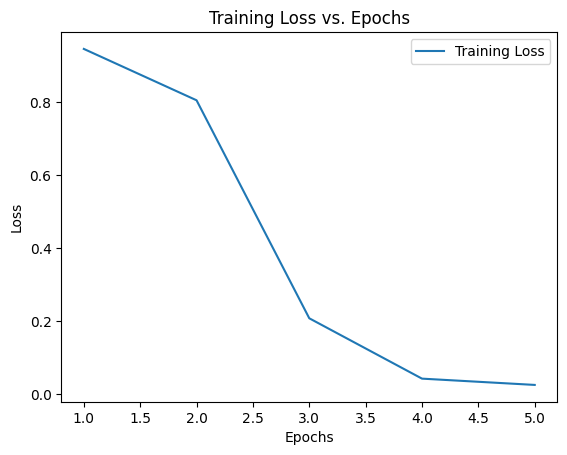

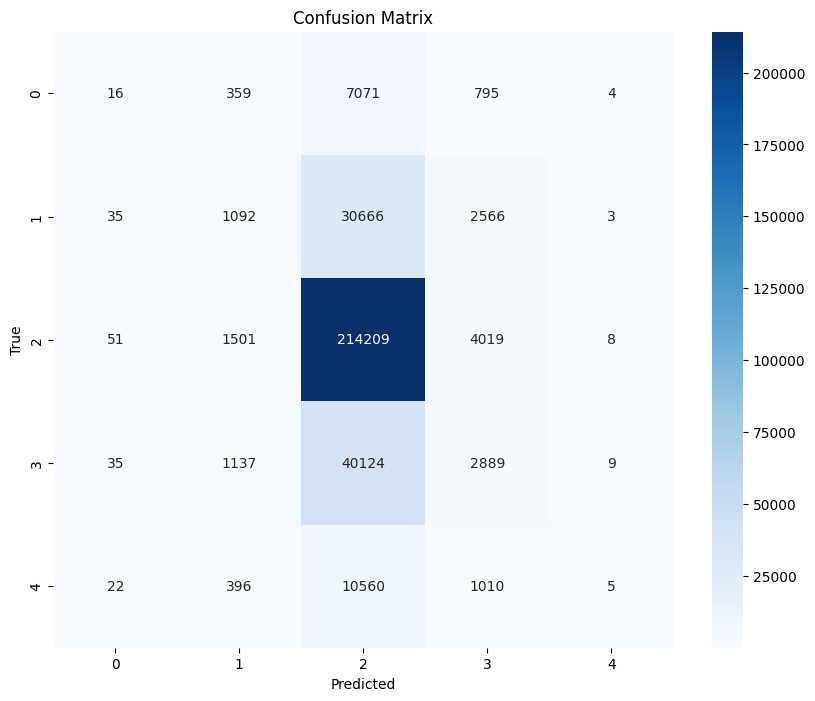

training accuracy  0.6849445354728139


In [40]:
train(model, LR, 1)


Loading test trees..
done
Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.00      0.00      2008
           1       0.26      0.03      0.06      9255
           2       0.70      0.97      0.82     56548
           3       0.23      0.06      0.10     10998
           4       0.00      0.00      0.00      3791

    accuracy                           0.68     82600
   macro avg       0.26      0.21      0.19     82600
weighted avg       0.54      0.68      0.58     82600

Confusion Matrix:


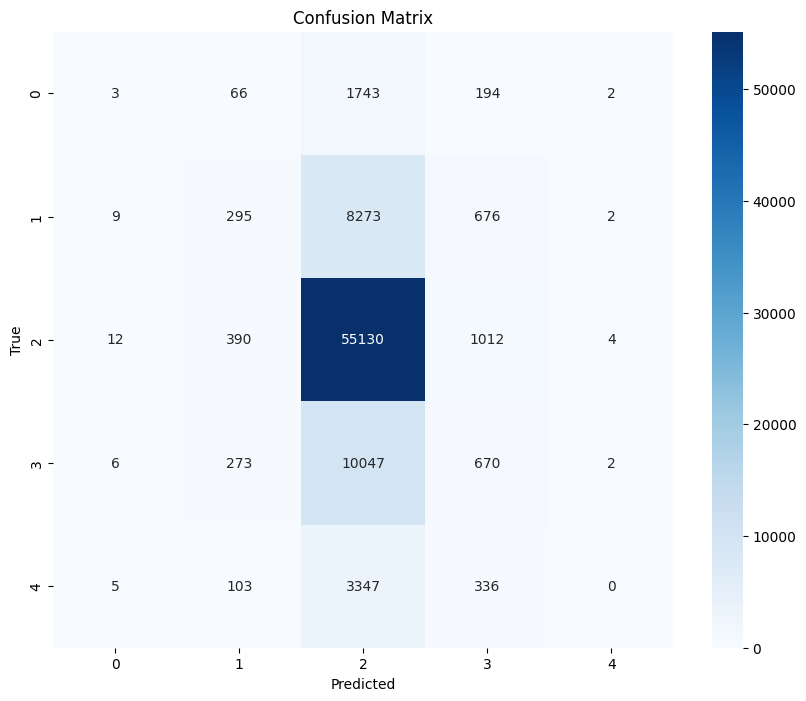

In [41]:
test(model)